## Understanding inter-layer structure dependencies

When we prune channels and filters from convolutional layers, we need to take into consideration the dependent layers, which are affected by this change.  For example, removing a single filter from a convolution means that its feature-map is smaller and the next layer (e.g. Batch Normalization, Convolution, etc.) needs to be adjusted accordingly.
In networks which have non-trivial connectivity, ResNet for example, the dependencies may ripple down many layers and can become complex.

This notebook shows how you can use Distiller's SummaryGraph class to analyze detect these dependencies and graph them to a PNG diagram.

In [1]:
# Relative import of code from distiller, w/o installing the package
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
    
import distiller
from distiller.model_summaries import *
from distiller.models import create_model
from distiller.apputils import *
import torch
import torchvision
import qgrid
from torch.autograd import Variable

# Load some common jupyter code
%run distiller_jupyter_helpers.ipynb
import ipywidgets as widgets
from ipywidgets import interactive, interact, Layout

## Choose which model you want to examine

In [2]:
#dataset = 'imagenet'
#arch = 'vgg16'
dataset = 'cifar10'
arch = 'resnet20_cifar'

checkpoint_file = None 

if checkpoint_file is not None:
    model = create_model(pretrained=False, dataset=dataset, arch=arch)
    load_checkpoint(model, checkpoint_file)
else:
    model = create_model(pretrained=False, dataset=dataset, arch=arch, parallel=False)

In [3]:
dummy_imagenet_input = Variable(torch.randn(1, 3, 224, 224), requires_grad=False)
dummy_cifar_input = Variable(torch.randn(1, 3, 32, 32), requires_grad=False)

dummy_input = dummy_imagenet_input if dataset=='imagenet' else dummy_cifar_input

g = distiller.SummaryGraph(model, dummy_input)
df = connectivity_summary(g)
qgrid.set_grid_option('defaultColumnWidth', 10)
qgrid.show_grid(df)
len(df)

80

In [4]:
op_names = [op['name'] for op in g.ops.values() if op['type']=='Conv']
print(op_names)

succs = g.successors_f('features2', 'Conv')
print(succs)

['layer3.2.conv1', 'layer3.0.conv1', 'layer2.2.conv2', 'layer2.0.conv1', 'layer2.1.conv2', 'conv1', 'layer1.2.conv1', 'layer2.0.downsample.0', 'layer2.1.conv1', 'layer2.0.conv2', 'layer3.0.downsample.0', 'layer3.1.conv1', 'layer3.1.conv2', 'layer2.2.conv1', 'layer1.2.conv2', 'layer3.0.conv2', 'layer1.1.conv2', 'layer1.0.conv1', 'layer1.1.conv1', 'layer1.0.conv2', 'layer3.2.conv2']
[]


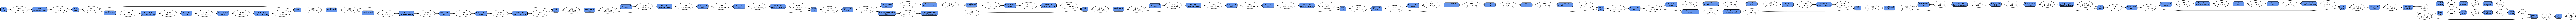

In [5]:
from IPython.display import Image

# Draw on notebook
png = create_png(g, rankdir="LR")
Image(png, embed=True, unconfined=True)#, width=6400)#, height=200)

In [6]:
succs = g.successors_f('conv1', 'Conv')
print(succs)

['layer1.0.conv1', 'layer1.1.conv1', 'layer1.2.conv1', 'layer2.0.conv1', 'layer2.0.downsample.0']


In [7]:
succs = g.successors('layer1.1.conv1', 4)
print(succs)

['layer1.1.relu1']


In [8]:
for depth in range(15):
    succs = g.successors('conv1', depth=depth)
    print(succs)

[]
['129']
['bn1']
['130']
['relu']
['131']
['layer1.0.conv1', 'Add']
['132', '137']
['layer1.0.bn1', 'layer1.0.relu2']
['133', '138']
['layer1.0.relu1', 'layer1.1.conv1', 'Add1']
['134', '139', '144']
['layer1.0.conv2', 'layer1.1.bn1', 'layer1.1.relu2']
['135', '140', '145']
['layer1.0.bn2', 'layer1.1.relu1', 'layer1.2.conv1', 'Add2']


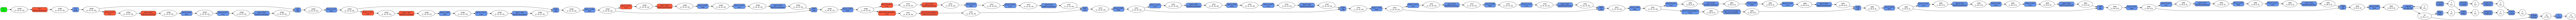

In [9]:
from copy import deepcopy

#layer_under_examination = 'layer2.0.conv2'
layer_under_examination = 'conv1'

# Drawing styles
style_node_dependents = {'shape': 'record',
                         'fillcolor': '#FF5733',
                         'style': 'rounded, filled'}
style_node_source = {'shape': 'record',
                     'fillcolor': 'green',
                     'style': 'rounded, filled'}

# Search for successors
succs = g.successors_f(layer_under_examination, 'Conv')
succs.append(layer_under_examination)
succs2 = deepcopy(succs)
for succs_conv in succs:
    if isinstance(succs_conv, list):
        succs2 += succs_conv
    succs2 += g.successors_f(succs_conv, 'BatchNormalization')

styles = {module: style_node_dependents for module in succs2}
styles[layer_under_examination] = style_node_source
    
# Draw the graph
png = create_png(g, rankdir="LR", styles=styles)
Image(png, embed=True, unconfined=True)